# Enzyme Kinetic Parameter Inference
> Supposing you observe a timeseries of concentrations of metabolites, can you infer the kinetic parameters for the enzyme? 

- hide: true


In [7]:
#collapse
# imports
from itertools import combinations_with_replacement, product
from collections import Counter
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.stats.kde import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import Matern

import ipywidgets as widgets
from IPython.display import display
            
%config InlineBackend.figure_format = 'retina'

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000

%load_ext jupyternotify
import os
# os.system("printf '\a'") # or '\7'

exp = np.exp
sin = np.sin
cos = np.cos
sqrt = np.sqrt
Π = np.prod
π = np.pi
N = np.random.normal

def is_power_of_2(x): return x > 4 and (x & (x-1) == 0)

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
#collapse
# simple matrix view macro
import PIL.Image
from matplotlib.pyplot import imshow
def show(*Ms): 
    fig, axs = plt.subplots(ncols=len(Ms))
    for M, ax in zip(Ms, (axs if type(axs) == list else [axs])):
        M = np.atleast_2d(M)
        ax.imshow(PIL.Image.fromarray((M - M.min()) * 255 / M.max()))
        ax.set_xticks([0, M.shape[1]])
        ax.set_yticks([0, M.shape[0]])
        for side in ["right","top","bottom","left"]:
            ax.spines[side].set_visible(False)
    return fig, axs

In [3]:
#collapse
# simple distrib pdf view macro
from scipy.stats import weibull_min, dweibull, dgamma, expon as exponential
from scipy.stats import rv_discrete, rv_continuous

def is_discrete(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_discrete)
    else: return isinstance(dist, rv_discrete)

def is_continuous(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_continuous)
    else: return isinstance(dist, rv_continuous)

def plot_distrib(distrib, title=None):
        
    fig, ax = plt.subplots(1, 1)
    
    if is_continuous(distrib):
        x = np.linspace(distrib.ppf(0.01),
                        distrib.ppf(0.99), 100)       
        ax.plot(x, distrib.pdf(x), 'k-', lw=0.4)
    
    elif is_discrete(distrib):
        x = np.arange(distrib.ppf(0.01),
                      distrib.ppf(0.99))
        ax.plot(x, distrib.pmf(x), 'bo', ms=2, lw=0.4)

    r = distrib.rvs(size=1000)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=100)

    if title: ax.set_title(title)
    return ax
    

## 1. Background

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}
\newcommand{\kcat}{k_{\mathrm{cat}}}
\newcommand{\kuncat}{k_{\mathrm{uncat}}}
\newcommand{\dSdt}{\frac{d[\mathrm{S}]}{dt}}
\newcommand{\dEdt}{\frac{d[\mathrm{E}]}{dt}}
\newcommand{\dESdt}{\frac{d[\mathrm{ES}]}{dt}}
\newcommand{\dPdt}{\frac{d[\mathrm{P}]}{dt}}$$
### 1.1 Enzyme Kinetics
Enzymes catalyze many critical chemical reactions in cells. 

Describing a cell with a mathematical model (a long-standing goal of computational biologists) would entail modelling each enzyme-catalyzed chemical reaction. 

However, although we may know the _scheme_ for many enzymatic reactions (the responsible enzyme, the associated substrates, and resultant reaction products) we are often missing many of the details needed to construct a faithful mathematical model of the reaction. 

Let's begin by introducing the mathematical model used to describe enzymatic reaction schemes. Consider the following enzymatically-catalyzed (uni uni) chemical reaction scheme:

$$ E+S \underset{\koff}{\overset{\kon}{\rightleftarrows}} ES \underset{\kuncat}{\overset{\kcat}{\rightleftarrows}}E+P $$

In this scheme E is an enzyme, S is its substrate, ES is the enzyme-substrate complex, which is an intermediate, and P is the product of the reaction. Each of those chemical species has a concentration in a fixed volume, which we denote with brackets (e.g. [E] = enzyme concentration). 

If we make the simplifying assumption that the 4 molecular species are 'well-mixed' in solution, we can invoke the '[Law of Mass Action](https://en.wikipedia.org/wiki/Law_of_mass_action)' under which the rate of each of the four included reactions is linear in the concentrations of the reactants (with an associated rate constant coefficient). The reactions in the above scheme are: enzyme-substrate association ($\kon$), dissociation ($\koff$), enzyme catalysis of substrate into product ($\kcat$), and enzyme-product re-association ("uncatalysis", $\kuncat$). The 'direction' of the reaction, and the designation of 'substrate' and 'product' is our choice -- the model is entirely symmetric, which is reflected in the associated ODEs:

$$\begin{aligned}
    \frac{d[\mathrm{S}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\
    \frac{d[\mathrm{E}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] + k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{ES}]}{dt} &= - k_{\mathrm{off}}[\mathrm{ES}] + k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] - k_{\mathrm{cat}}[\mathrm{ES}] + k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{P}]}{dt} &= k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] 
\end{aligned}$$

This differential equation model describing the (deterministic) chemical kinetics for an enzymatically-catalyzed reaction in well-mixed conditions contains 4 kinetic parameters, i.e. 4 degrees of freedom, which we do not know _a priori_. These will be the subject of inference.

> Note: the intracellular environment is not best described as well-mixed, and models of '[Macromolecular Crowding](https://en.wikipedia.org/wiki/Macromolecular_crowding)' have led to more accurate rate laws for these reactions _in vivo_. However, we will retain the well-mixed assumption for now.

### 1.2 Parameter Inference

There are 3 typical problems associated with ODE models:

- Supplied with a complete specification of the system, the **forward problem** is to integrate the differential equations from some initial conditions forwards in time and predict the trajectory of the system. This is what is typically meant by "solving" the ODE system, but exact analytical solutions are rare, and [numerical methods](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) are often brought to bear to approximate system trajectories.
- Supplied with one or more trajectories (data) but incomplete specification of the system, the **inverse problem** is to estimate parameters of the system (coefficients in the ODE expressions). 
- Finally, given some manipulable inputs, the **control problem** is to drive the system towards some desired state.

This post will explore a range of approaches for the inverse problem. Our goal will be to estimate the kinetic parameters of enzymatically-catalyzed chemical reactions from timeseries of concentrations of the molecular species. 

> Note: enzyme kinetic parameters are typically not inferred from metabolite timeseries data using the methods we will describe, but instead from specific [enzyme assays](https://en.wikipedia.org/wiki/Enzyme_assay). However, at the moment, these assays are limited to studying one enzyme at a time. The inference approaches described in this post can leverage data from emerging high-throughput assays. 


The determination of the kinetic parameters for the enzymatic reactions of life is a major project, and reported values have been tabulated in databases such as [BRENDA](https://www.brenda-enzymes.org/). However, my experience with these databases has been that the reported kinetic parameters appear to be severely unreliable. 


### 1.3 The Michaelis-Menten/Briggs-Haldane Approximation

Two assumptions commonly made at this point are:
- to suppose that the rates of enzyme-substrate association ($\kon$) and dissociation ($\koff$) are greater than the rates for enzyme and product ($\kon$, $\koff$ $\gg$ $\kcat$, $\kuncat$).
- to assume the initial substrate concentration is much larger than the enzyme concentration ($[\mathrm{S_0}] > [\mathrm{E_0}]$). 
These assumptions permit a timescale separation argument called the "Quasi-Steady-State Approximation" (QSSA) permits us to set $\dESdt = 0$. From this approximation, we can [derive](http://www.bio-physics.at/wiki/index.php?title=Reversible_Michaelis_Menten_Kinetics) the traditional Reversible Michaelis-Menten/Briggs-Haldane expression:

$$\begin{aligned}
\frac{d[\mathrm{P}]}{dt} &= 
\frac{
\frac{\kcat \, [\mathrm{E_T}] [\mathrm{S}]}{K_{m,\mathrm{S}}} - 
\frac{\koff \, [\mathrm{E_T}] [\mathrm{P}]}{K_{m,\mathrm{P}}}}
{1+\frac{[\mathrm{S}]}{K_{m,\mathrm{S}}} + \frac{[\mathrm{P}]}{K_{m,\mathrm{P}}}} \\ \\
\frac{d[\mathrm{S}]}{dt} &= -\frac{d[\mathrm{P}]}{dt}
\end{aligned}$$

in which we have introduced the "Michaelis Constants": $K_{m,\mathrm{S}} = \frac{\koff + \kcat}{\kon}$ and $K_{m,\mathrm{P}} = \frac{\kcat + \koff}{\kuncat}$. 

The QSSA reduces the system from 4 variables to 2. There are still 4 kinetic parameters to estimate in this reduced model. 

> Note: _another_ assumption typically made at this point is to assume that catalysis is irreversible, leading to a further simplified expression for the rate of product formation $\frac{d[\mathrm{P}]}{dt}$. However, this assumption is quite often inaccurate, so we will not make it. 

## 2. Exploring the Forward Model

Before we explore techniques to estimate enzyme kinetic parameters from timeseries data, we need to generate timeseries data from the model to begin with, i.e. we need to solve the forward problem, given kinetic parameters. It will turn out that integrating the model forwards is a subroutine of both approaches to the inverse problem we'll see in this post.

For our first go, let's first use some generic rate constants:
- $\kon \,$  of $10^6$ events per Mol per second, or 1 per μM per second, is a typical rate for enzyme-substrate binding.
- $\koff \,$  of 100/s results in a $\koff$/$\kon$ = $k_d$ of 100 μM, which is a typical $k_d$.
- $\kcat \,$  is 100/s, a respectable $\kcat$.
- $\kuncat \,$  of $\frac{\kon}{10}$ is often considered as boundary for the QSSA to hold (so 0.1 per μM per second).

Calculations will be performed in μM and seconds. 

In [4]:
# Set ground-truth kinetic parameters
k_on = 1
k_off = 100
k_cat = 100
k_uncat = 0.1
k_ms = (k_off + k_cat) / k_on
k_mp = (k_off + k_cat) / k_uncat

kinetic_params = {'k_on':k_on, 'k_off':k_off, 'k_cat':k_cat, 'k_uncat':k_uncat, 'k_ms':k_ms, 'k_mp':k_mp}

There are a variety of numerical methods to integrate systems of differential equations. The most straightforward is [Euler's method](https://en.wikipedia.org/wiki/Euler_method), which we've written down explicitly for this system below: 

In [31]:
# define euler_full(), which integrates the full kinetics with Euler's Method, and returns a trajectory
def euler_full(E_0, S_0, dt, steps, **kinetic_params):
    
    S = S_0
    E = E_0
    ES = 0
    P = 0
#     k_on, k_off, k_cat, k_uncat, k_ms, k_mp = **kinetic_params
    traj = [[S, E, ES, P]]
    
    for _ in range(int(steps)):
        
        dSdt = k_off * ES - k_on * E * S
        dEdt = k_off * ES - k_on * E * S + k_cat * ES - k_uncat * E * P
        dESdt = k_on * E * S - k_off * ES - k_cat * ES + k_uncat * E * P
        dPdt = k_cat * ES - k_uncat * E * P
        
        S += dSdt * dt
        E += dEdt * dt
        ES += dESdt * dt
        P += dPdt * dt
    
        traj.append([S, E, ES, P])
    
    return pd.DataFrame(traj, columns=['S', 'E', 'ES', 'P'])

We'll also write down Euler's method for the Michaelis-Menten/Briggs-Haldane kinetics

In [33]:
# define euler_MM(), which integrates the Michaelis-Menten/Briggs-Haldane kinetics
def euler_MM(E_0, S_0, dt, steps, **kinetic_params):
            
    S = S_0
    E = E_0
    P = 0
#     k_on, k_off, k_cat, k_uncat, k_ms, k_mp = **kinetic_params
    traj = [[S, P]]
    
    for _ in range(int(steps)):
        
        dPdt = ((k_cat * E * S) / k_ms - (k_off * E * P) / k_mp) / (1 + S / k_ms + P / k_mp)        
        dSdt = -dPdt
        
        P += dPdt * dt
        S += dSdt * dt
    
        traj.append([S, P])
    
    return pd.DataFrame(traj, columns=['S_MM', 'P_MM'])

In order to produce a trajectory, we need to set **initial conditions**. We'll integrate the reaction kinetics of a hypothetical _in vitro_ experiment, in which enzyme and substrate are added to the reaction at the outset. 

- $[E]_0$, the initial enzyme concentration, is set to 1 miliMolar (mM), i.e. 1000μM. 
- $[S]_0$, the initial substrate concentration is set to 5.5 mM, the typical concentration of glucose in the blood. 

In [34]:
E_0 = 1e3
S_0 = 5.5e3

> _In vivo_ we would expect the concetration of enzyme to vary over time, and the substrate to be replenished. 

We also need to set the step size for our numerical integration, and the number of steps:

In [35]:
dt = 1e-6
steps = 1e5

In [36]:
traj_full = euler_full(E_0, S_0, dt, steps, **kinetic_params)
traj_mm = euler_MM(E_0, S_0, dt, steps, **kinetic_params)

In [43]:
#collapse
# figure styles
def fig_style(ax):
    for side in ["right","top"]: ax.spines[side].set_visible(False)
    ax.set_xlabel('time (s)',  weight='bold')
    ax.set_ylabel('concentration (μM)',  weight='bold')
    
def param_string(**kinetic_params): 
    return f'[k_on= {k_on}/μM/s]   [k_off = {k_off}/s]   [k_cat = {k_cat}/s]   [k_uncat = {k_uncat}/μM/s]   [E₀ = {int(E_0)}μM]   [S₀ = {int(S_0)}μM]'

c = {
    'S': 'dodgerblue',
    'E': 'sienna', 
    'ES': 'blue', 
    'P': 'darkblue',
    'S_MM': 'steelblue',
    'P_MM': 'slateblue'}

def color(df): return [c[col] for col in df.columns]

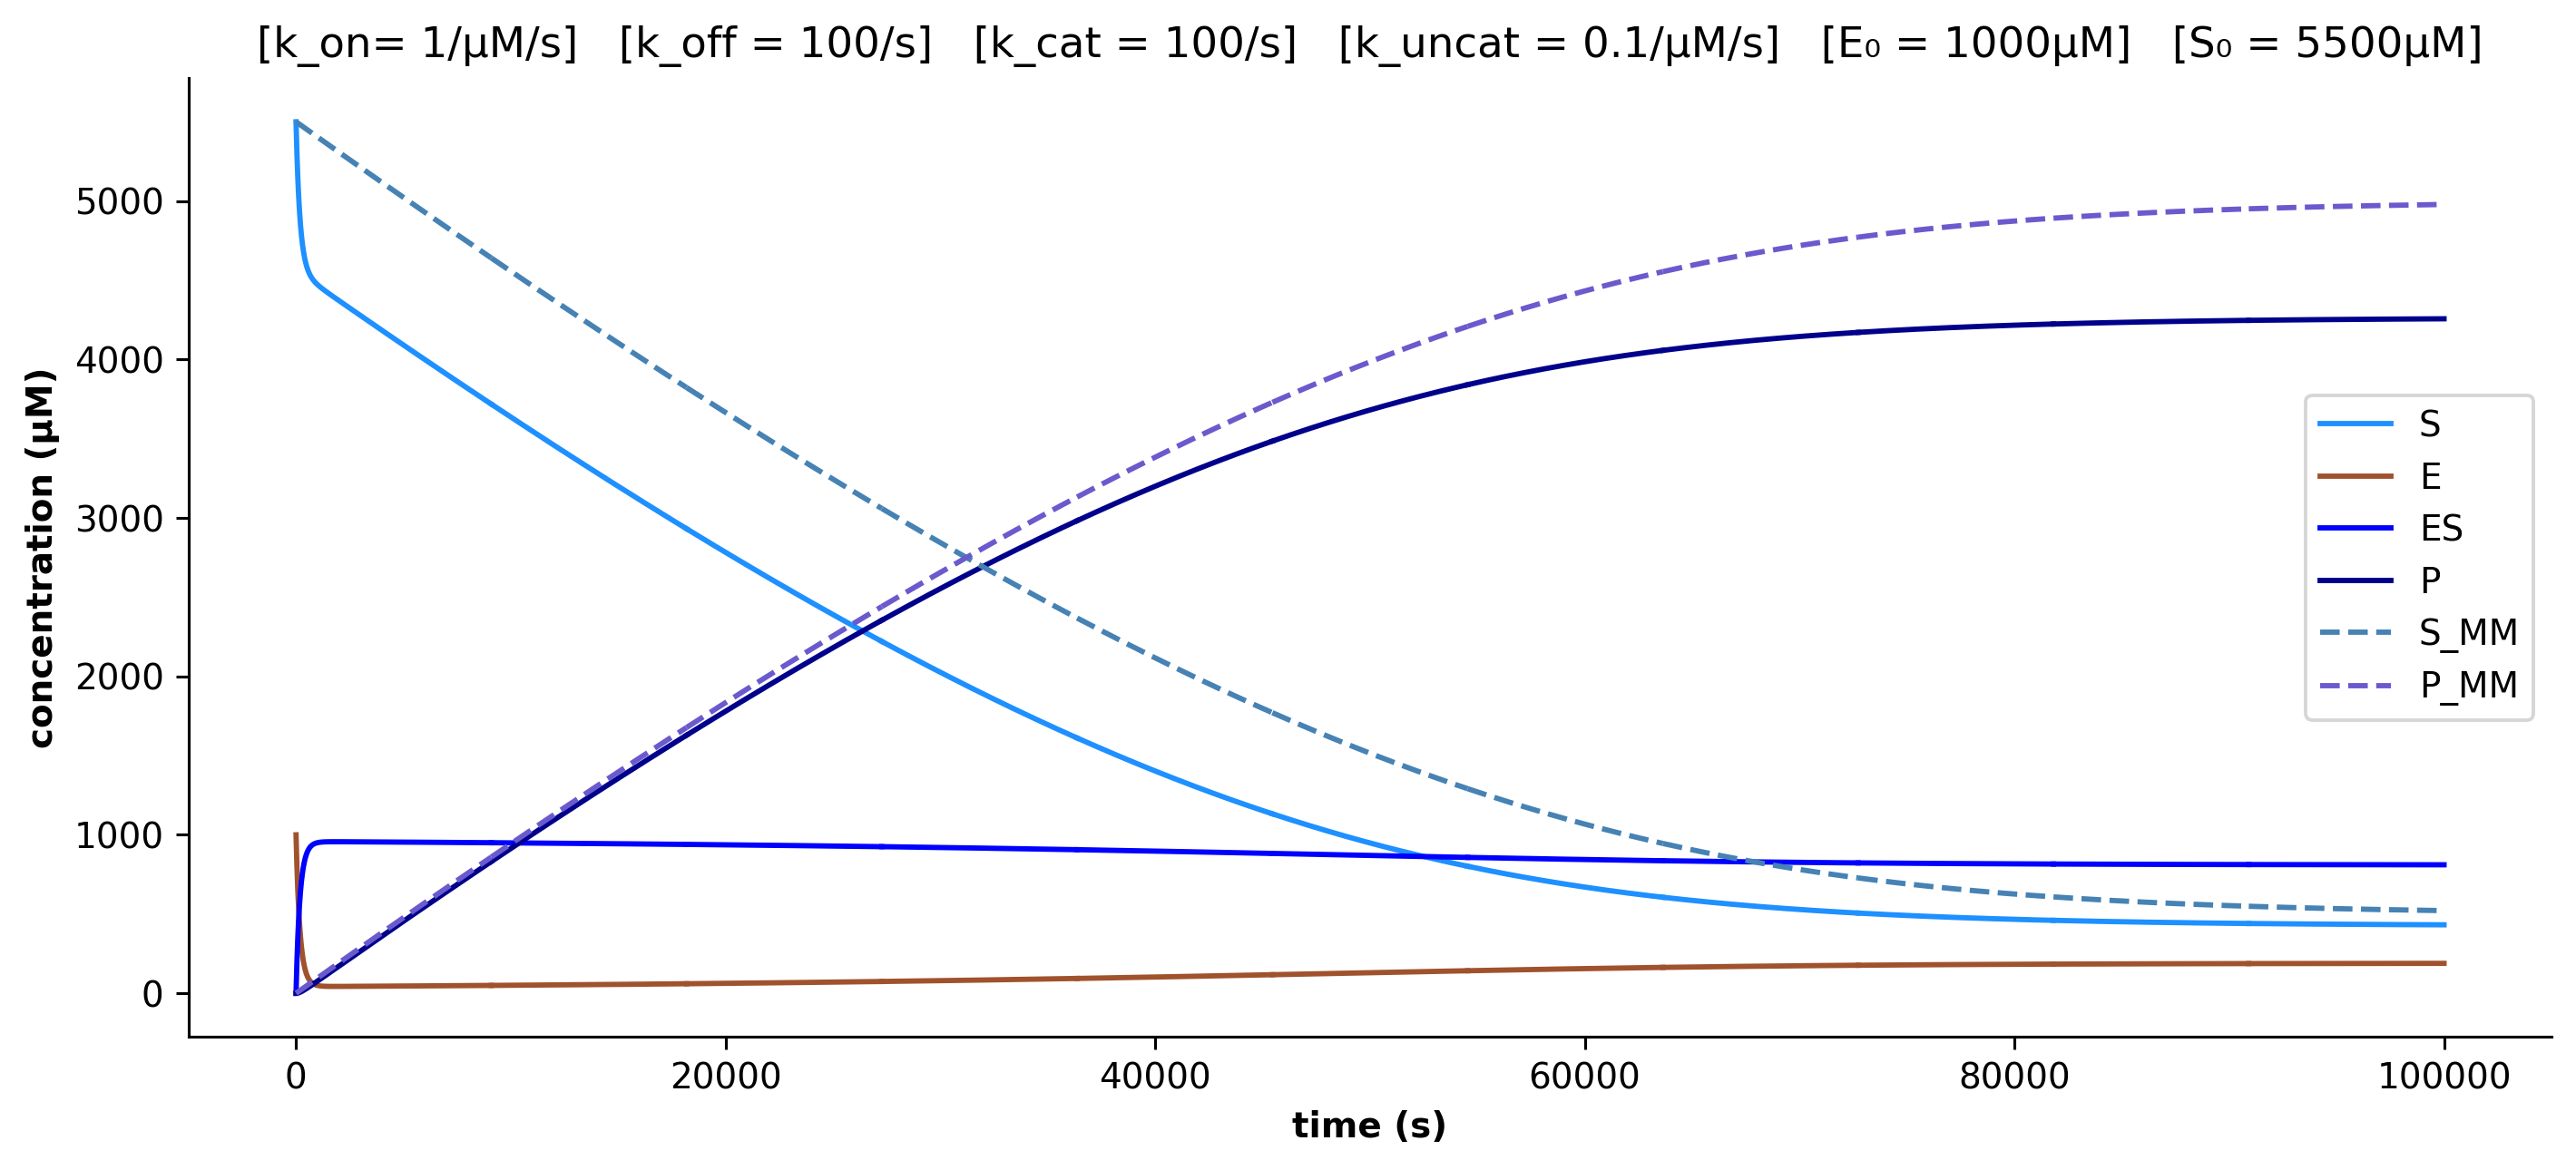

In [44]:
ax = traj_full.plot.line(title=param_string(**kinetic_params), color=color(traj_full))
traj_mm.plot.line(ax=ax, color=color(traj_mm), linestyle='--')

fig_style(ax)

We can plainly see the validity of the Quasi-Steady-State Approximation (QSSA) in action in the trajectory: Enzyme E and Substrate S rapidly form Enzyme-Substrate complex ES, which remains relatively constant throughout the course of the reaction.




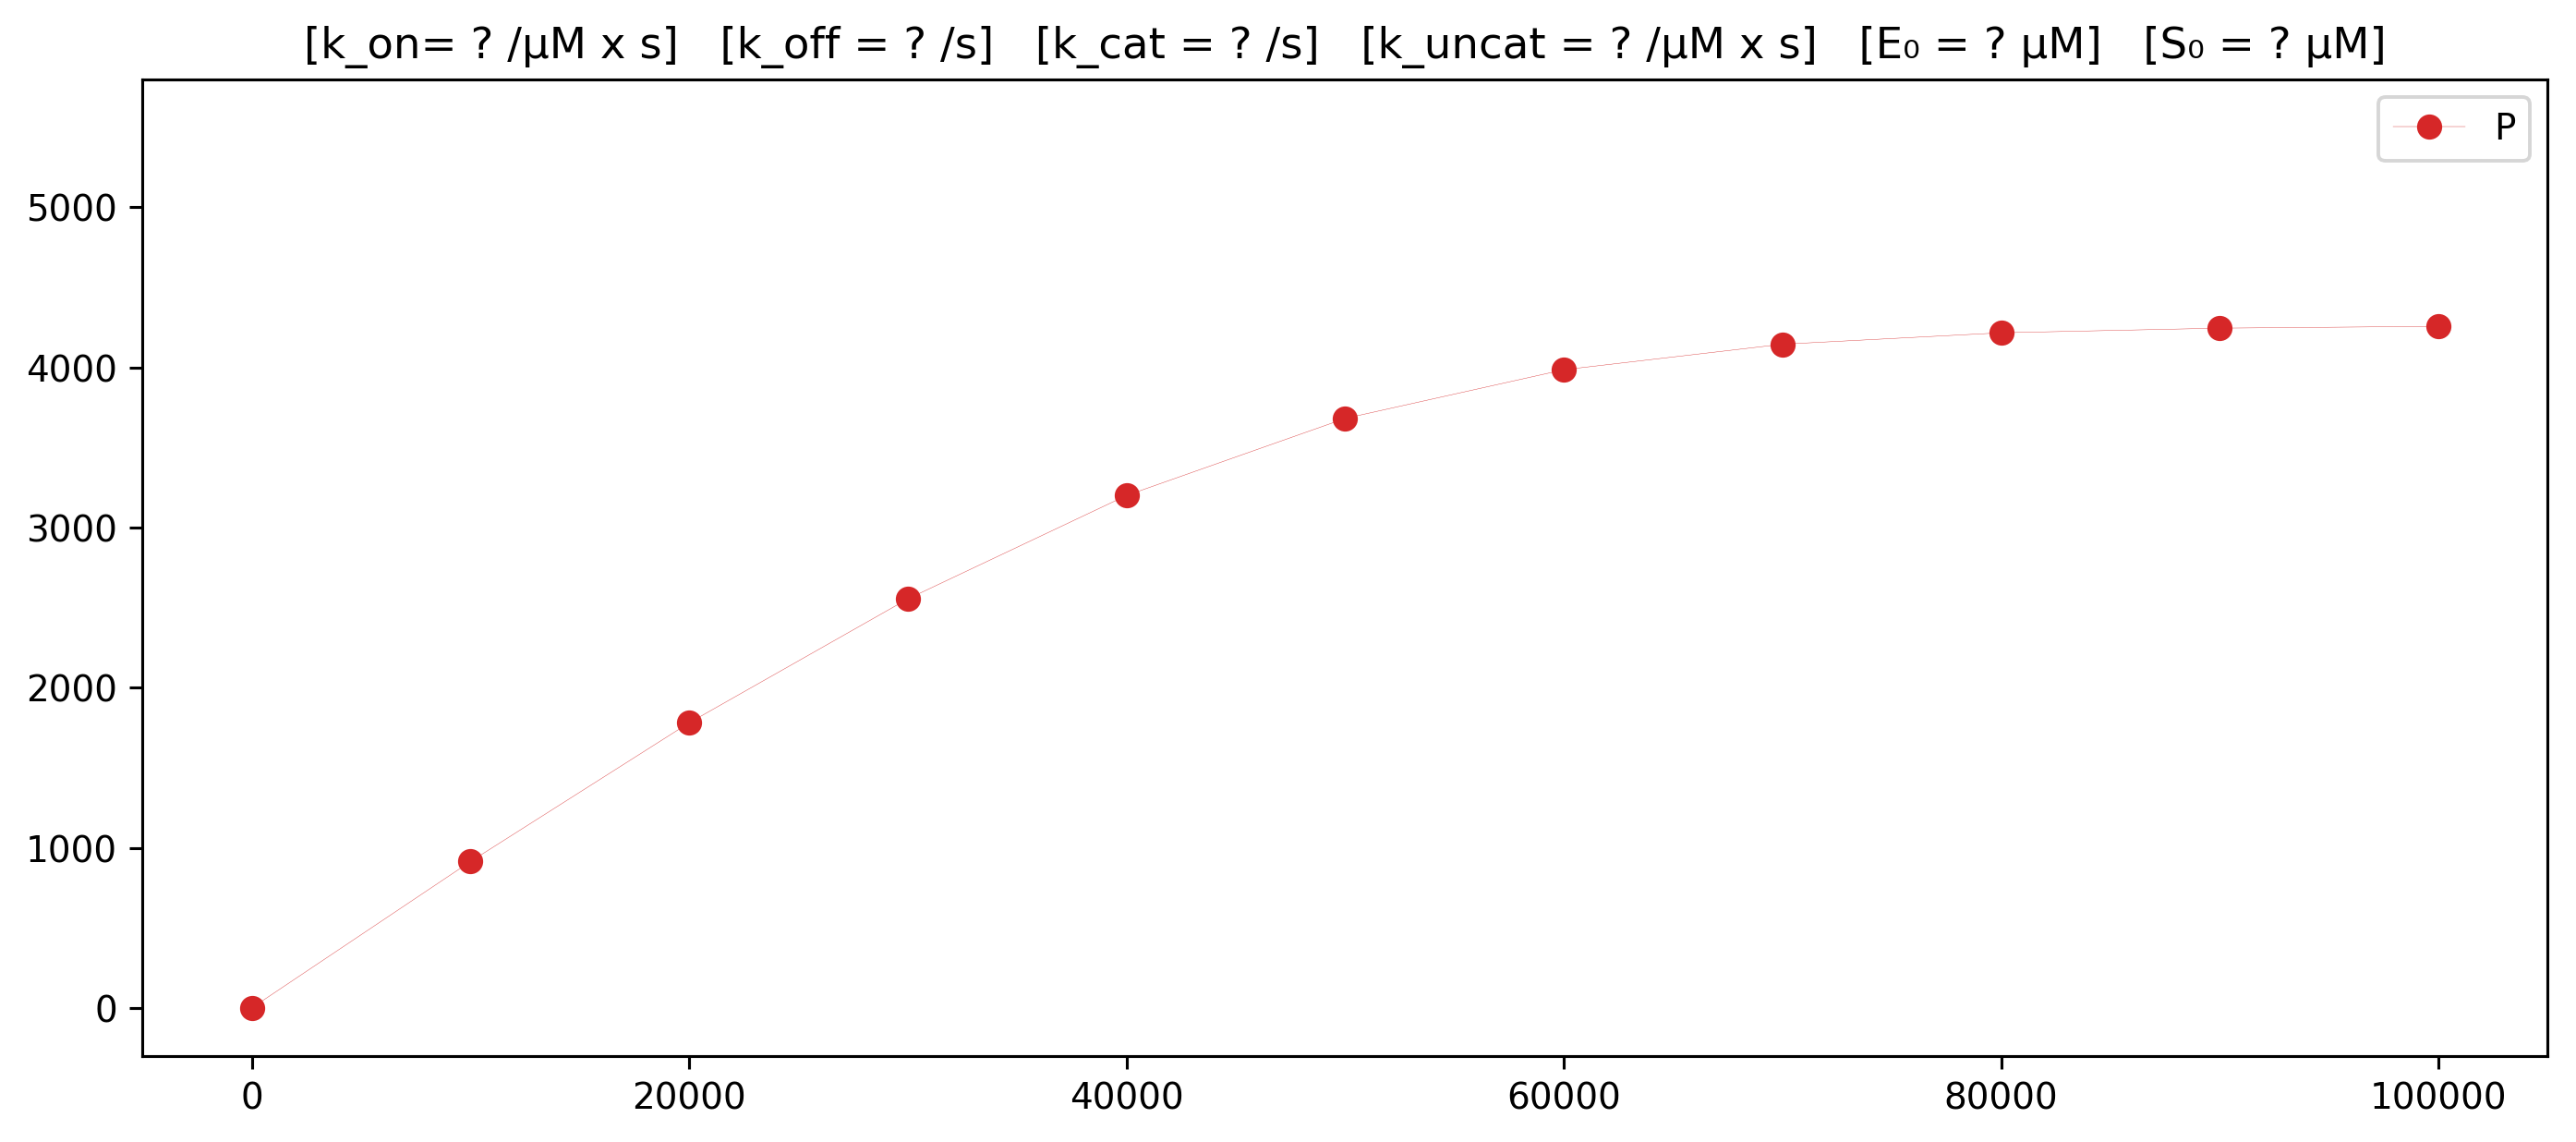

In [8]:
cmap = plt.get_cmap("tab10")

params = f'[k_on= ? /μM x s]   [k_off = ? /s]   [k_cat = ? /s]   [k_uncat = ? /μM x s]   [E₀ = ? μM]   [S₀ = ? μM]'

obs = traj['P'][traj['P'].index % 10000 == 0]

obs.plot.line(title=params, marker='o', lw=0.1, color=cmap(3), ylim=(-300, 5800), legend=True)

<Mention that we see this kind of curve and fit the parameters, but usually we're varying concentration, not observing a timeseries>

This appears to be a good moment to test the validity of the Michaelis-Menten expressions when the required assumptions are invalid.




### Violating the Michaelis-Menten/Briggs-Haldane Assumptions

#### Enzyme/Substrate Concentration Ratio Assumption

In [187]:
E = 5.5e3
S = 5.5e3
dt = 1e-6
steps = 1e5

traj = pd.DataFrame(integrate_full(E, S, dt, steps), columns=['S', 'E', 'ES', 'P', 'P_MM'])

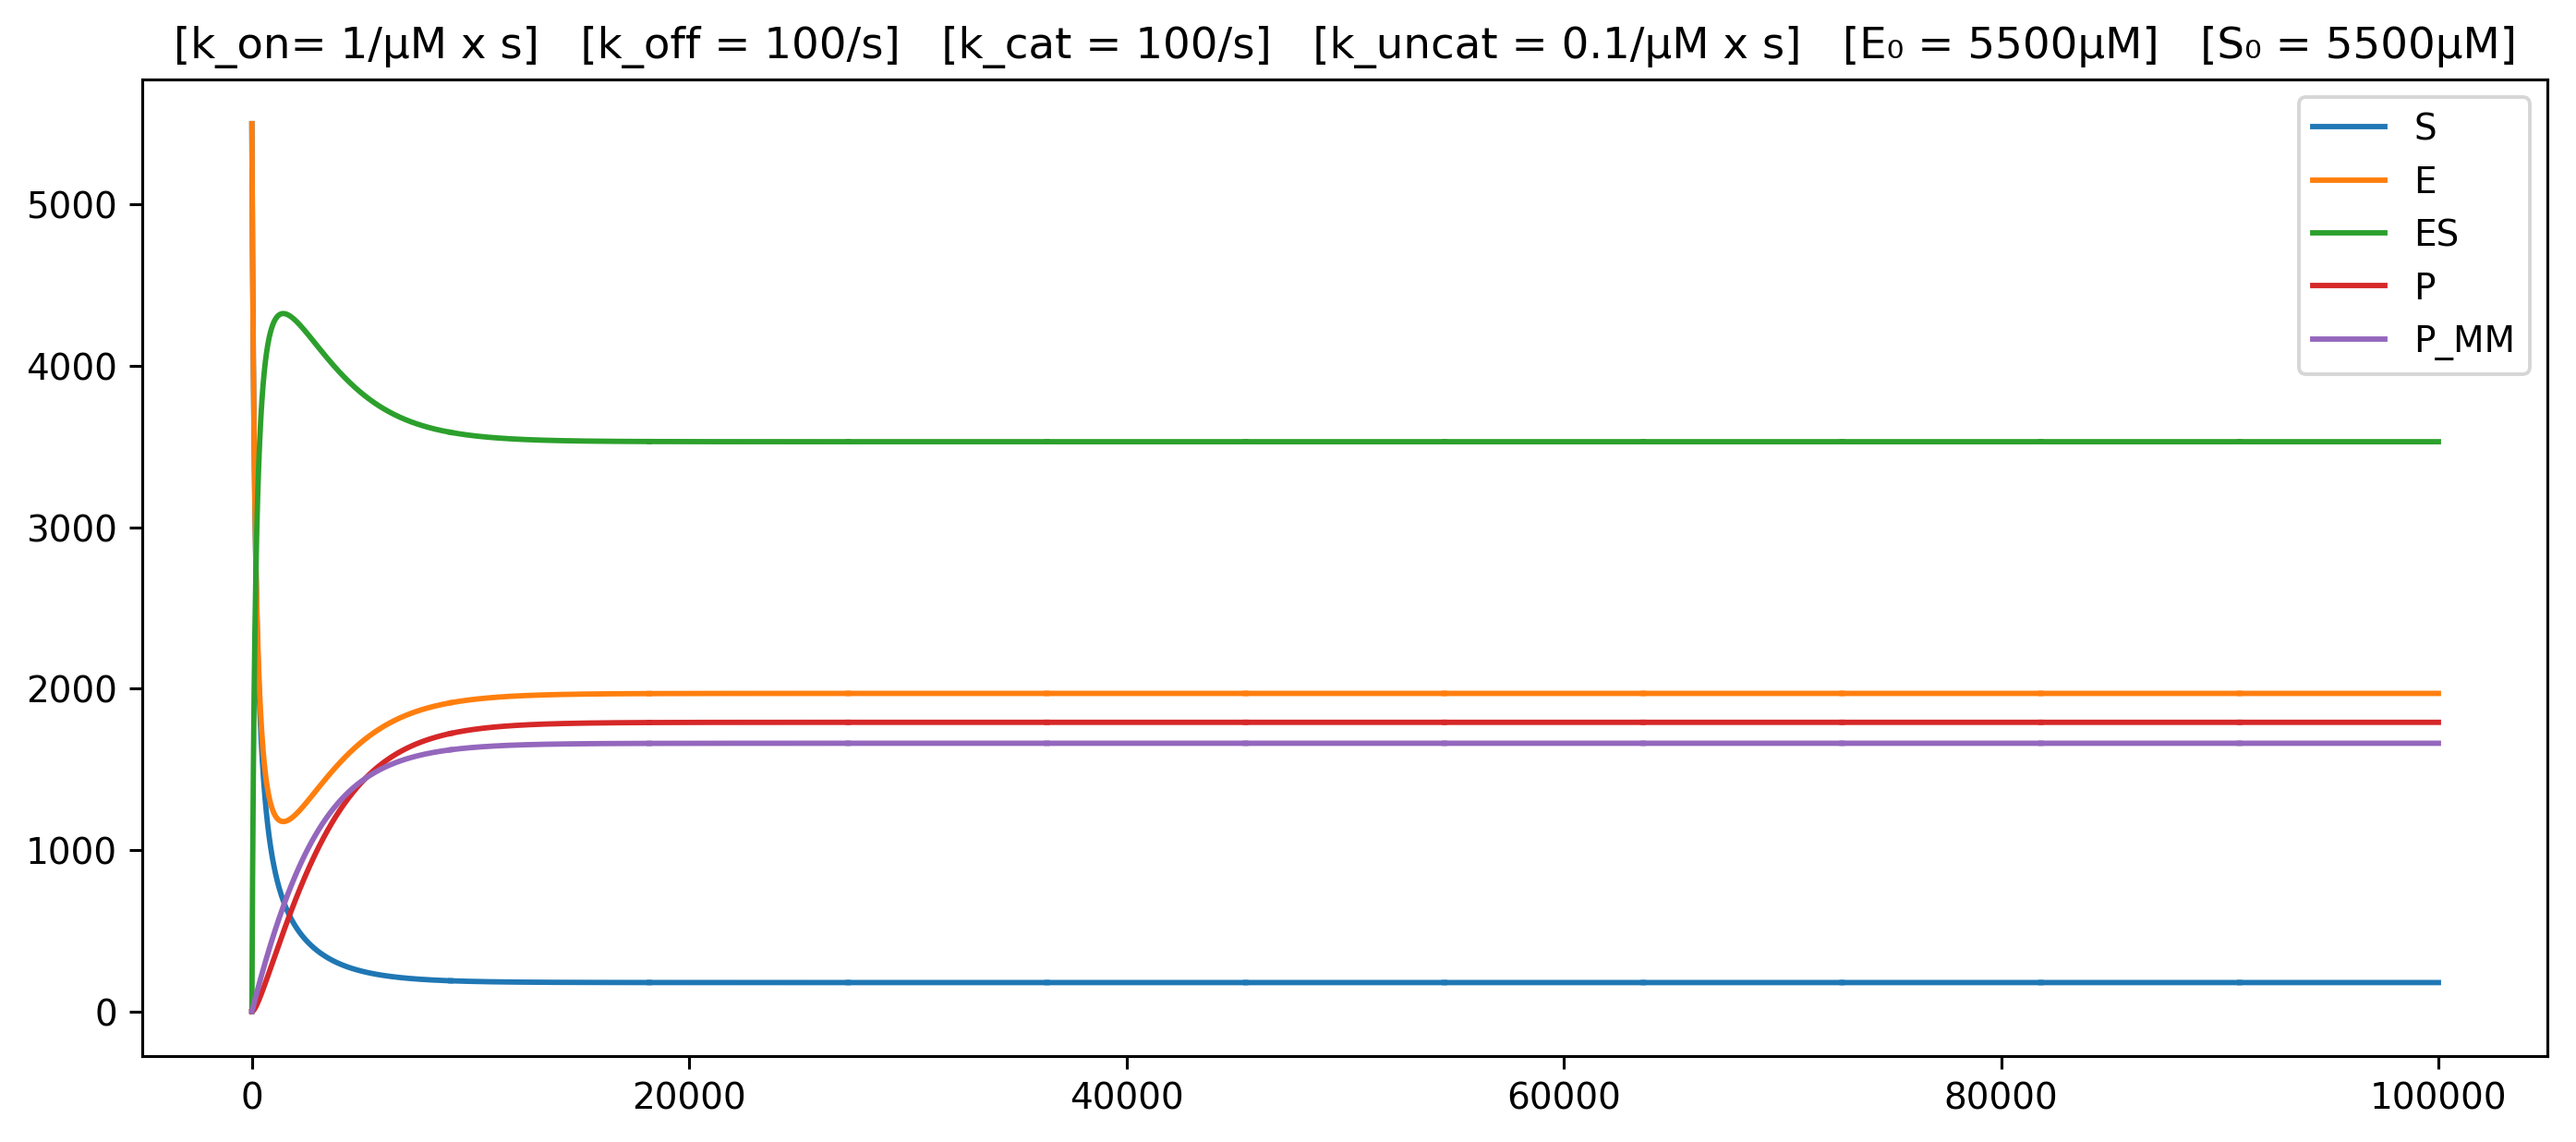

In [188]:
params = f'[k_on= {k_on}/μM x s]   [k_off = {k_off}/s]   [k_cat = {k_cat}/s]   [k_uncat = {k_uncat}/μM x s]   [E₀ = {int(E)}μM]   [S₀ = {int(S)}μM]'
traj.plot.line(title=params)

#### Quasi-Steady-State Approximation (QSSA)

ES takes a while to equilibrate

In [213]:
E = 5.5e3
S = 5.5e3
dt = 1e-6
steps = 1e5

k_on = 0.1     # in micromolar
k_off = 10     # in 1/s
k_cat = 100     # in 1/s
k_uncat = 0.1   # in micromolar

kms = (k_off + k_cat) / k_on
kmp = (k_off + k_cat) / k_uncat

kms, kmp

traj = pd.DataFrame(integrate_full(E, S, dt, steps, k_on=k_on, k_off=k_off, k_cat=k_cat, k_uncat=k_uncat), columns=['S', 'E', 'ES', 'P', 'P_MM'])

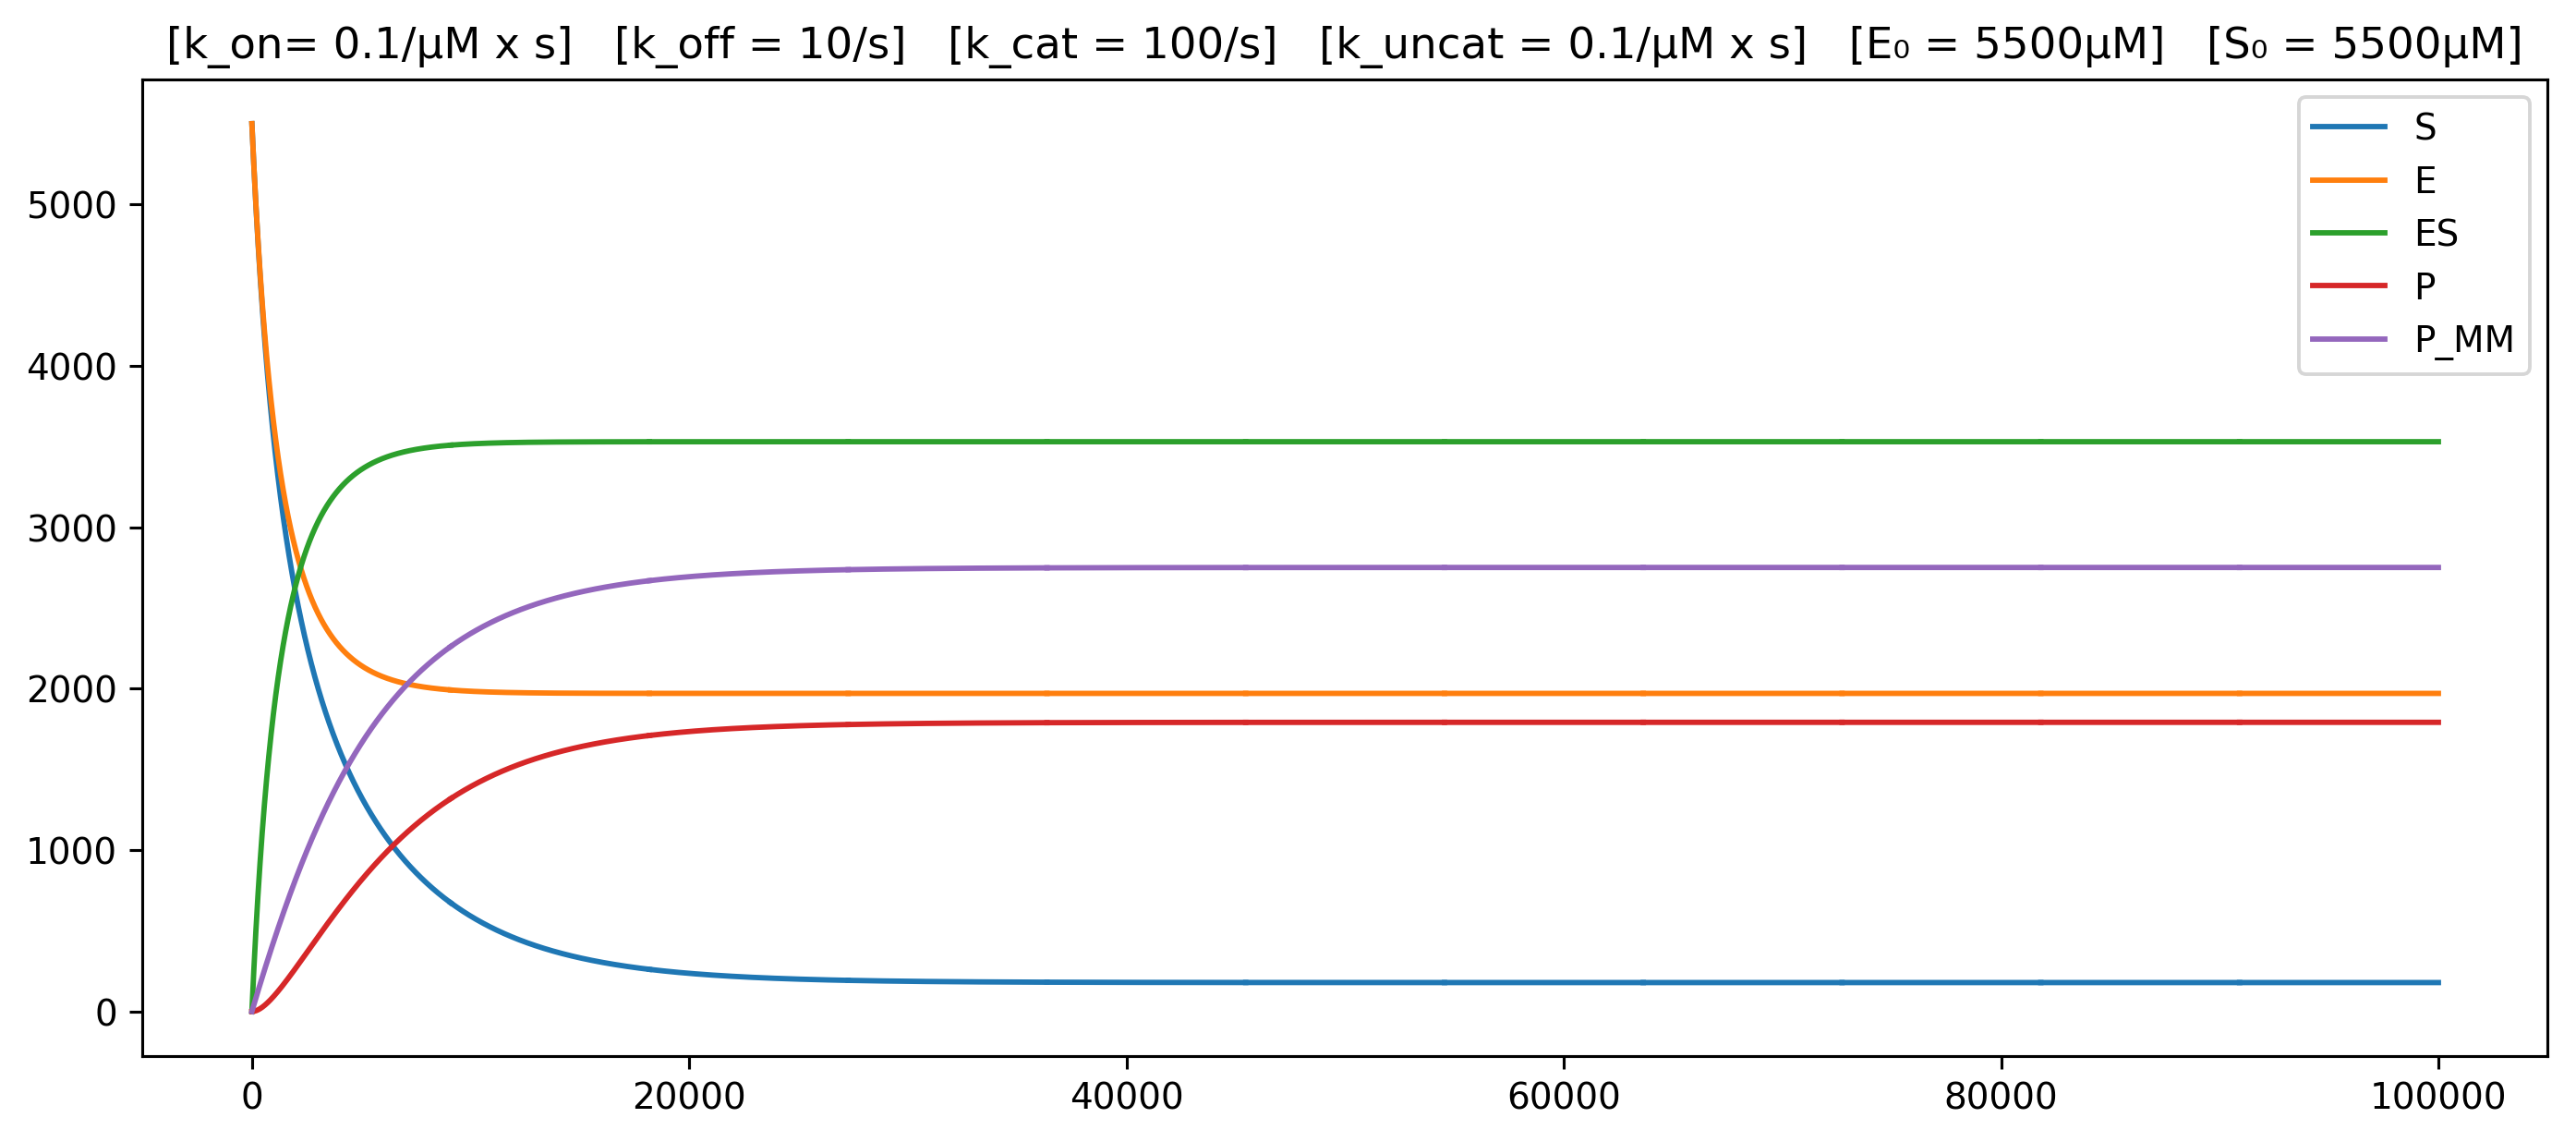

In [214]:
params = f'[k_on= {k_on}/μM x s]   [k_off = {k_off}/s]   [k_cat = {k_cat}/s]   [k_uncat = {k_uncat}/μM x s]   [E₀ = {int(E)}μM]   [S₀ = {int(S)}μM]'
traj.plot.line(title=params)

## 3. Inference


Now let's use MCMC to get a posterior over $\kcat$, $\kuncat$, $K_{m,\mathrm{S}}$, and $K_{m,\mathrm{P}}$ (from which we can derive $\kon \,$ and $\koff$ ) using the Michaelis Menten Kinetics expression for \dPdt. The likelihood is a gaussian around the observed concentration of P, sampled densely in time. 

## 2.1 Basic

# Need to spend some time defining decent priors

In [121]:
# kcat can range from 1e2 per second, to 1e6 per second, distribution is lognormal lets say. 
# if kon is 1 micromolar, and affinities can range from nanomolar to milimolar, then k_off must be between 1e-3 and 1e3. lognormal
# kon between 5e5 and 5e6 mean at 1e6, lognormal
# kuncat zero to 1e6, lognormal, mean at 1e2

# KM lies between 10^-1 and 10^-7 M

scipy.stats.lognorm?


In [175]:
params = np.array([kms, kmp, k_cat, k_off])
prior_cov = np.eye(4) * params/3
prior = multivariate_normal(mean=params, cov=prior_cov)

observational_noise = 1
likelihood_dist = multivariate_normal(mean=obs.values, cov=np.eye(len(obs)) * observational_noise)

observed_idx = obs.index.astype(int)

def MH_MCMC(chain_length=1e3):

    zt = prior.rvs()
    ut = integrate_MM(zt)['P']
    πt = -likelihood_dist.logpdf(ut.loc[observed_idx].values) #- prior.logpdf(zt)
    
    cov = prior_cov
    i = 0
    accept_ratio = 0
    chain = []
    samples = []
    
    while i < chain_length: 

        ztp1 = np.clip(np.random.multivariate_normal(zt, cov), 0, None)
        utp1 = integrate_MM(ztp1)['P']
        πtp1 = -likelihood_dist.logpdf(utp1.loc[observed_idx].values) #- prior.logpdf(zt)
        
        if πtp1 - πt < -np.log(np.random.rand()): 
            zt, ut, πt = ztp1, utp1, πtp1
            accept_ratio += 1 

        chain.append(zt)
        samples.append(ut.values)

        i += 1
        
        if i % 1e2 == 0 and i > 0:
            cov = np.cov(np.array(chain), rowvar=False)
            print(i, end='\r')

    return pd.DataFrame(chain, columns=['kms', 'kmp', 'k_cat', 'k_off']), pd.DataFrame(samples), accept_ratio/chain_length, cov


In [176]:
chain, samples, accept_ratio, cov = MH_MCMC()

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


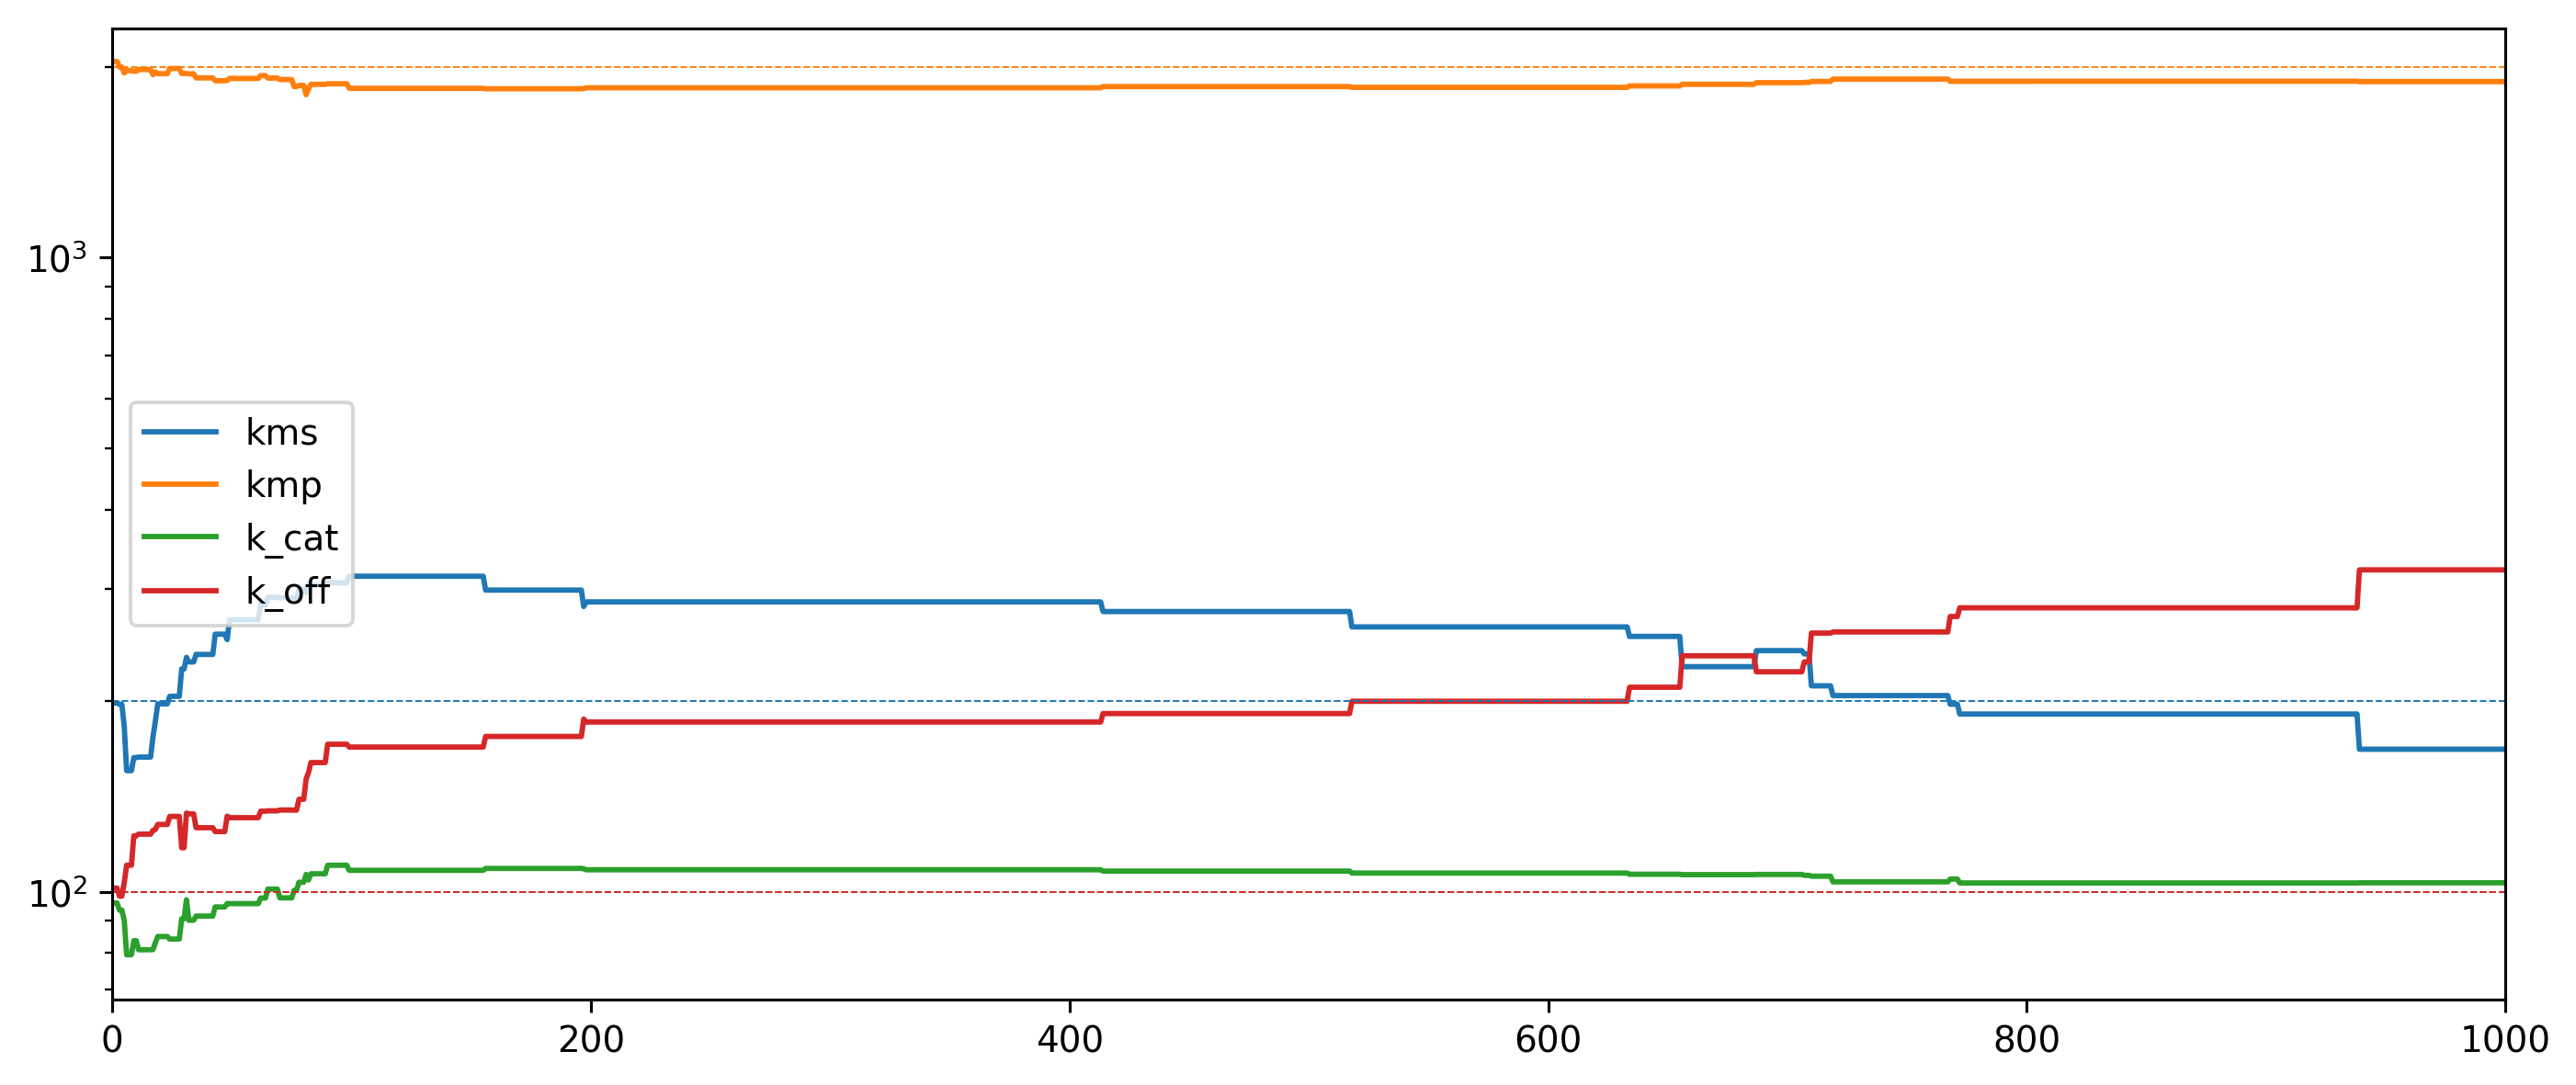

In [177]:
ax = chain.plot.line(ylim=(0, 2300), xlim=(0,1000), logy=True)

for i, param in enumerate(params): ax.axhline(param, lw=0.5, color=cmap(i), linestyle='--') 

In [178]:
params

array([ 200., 2000.,  100.,  100.])

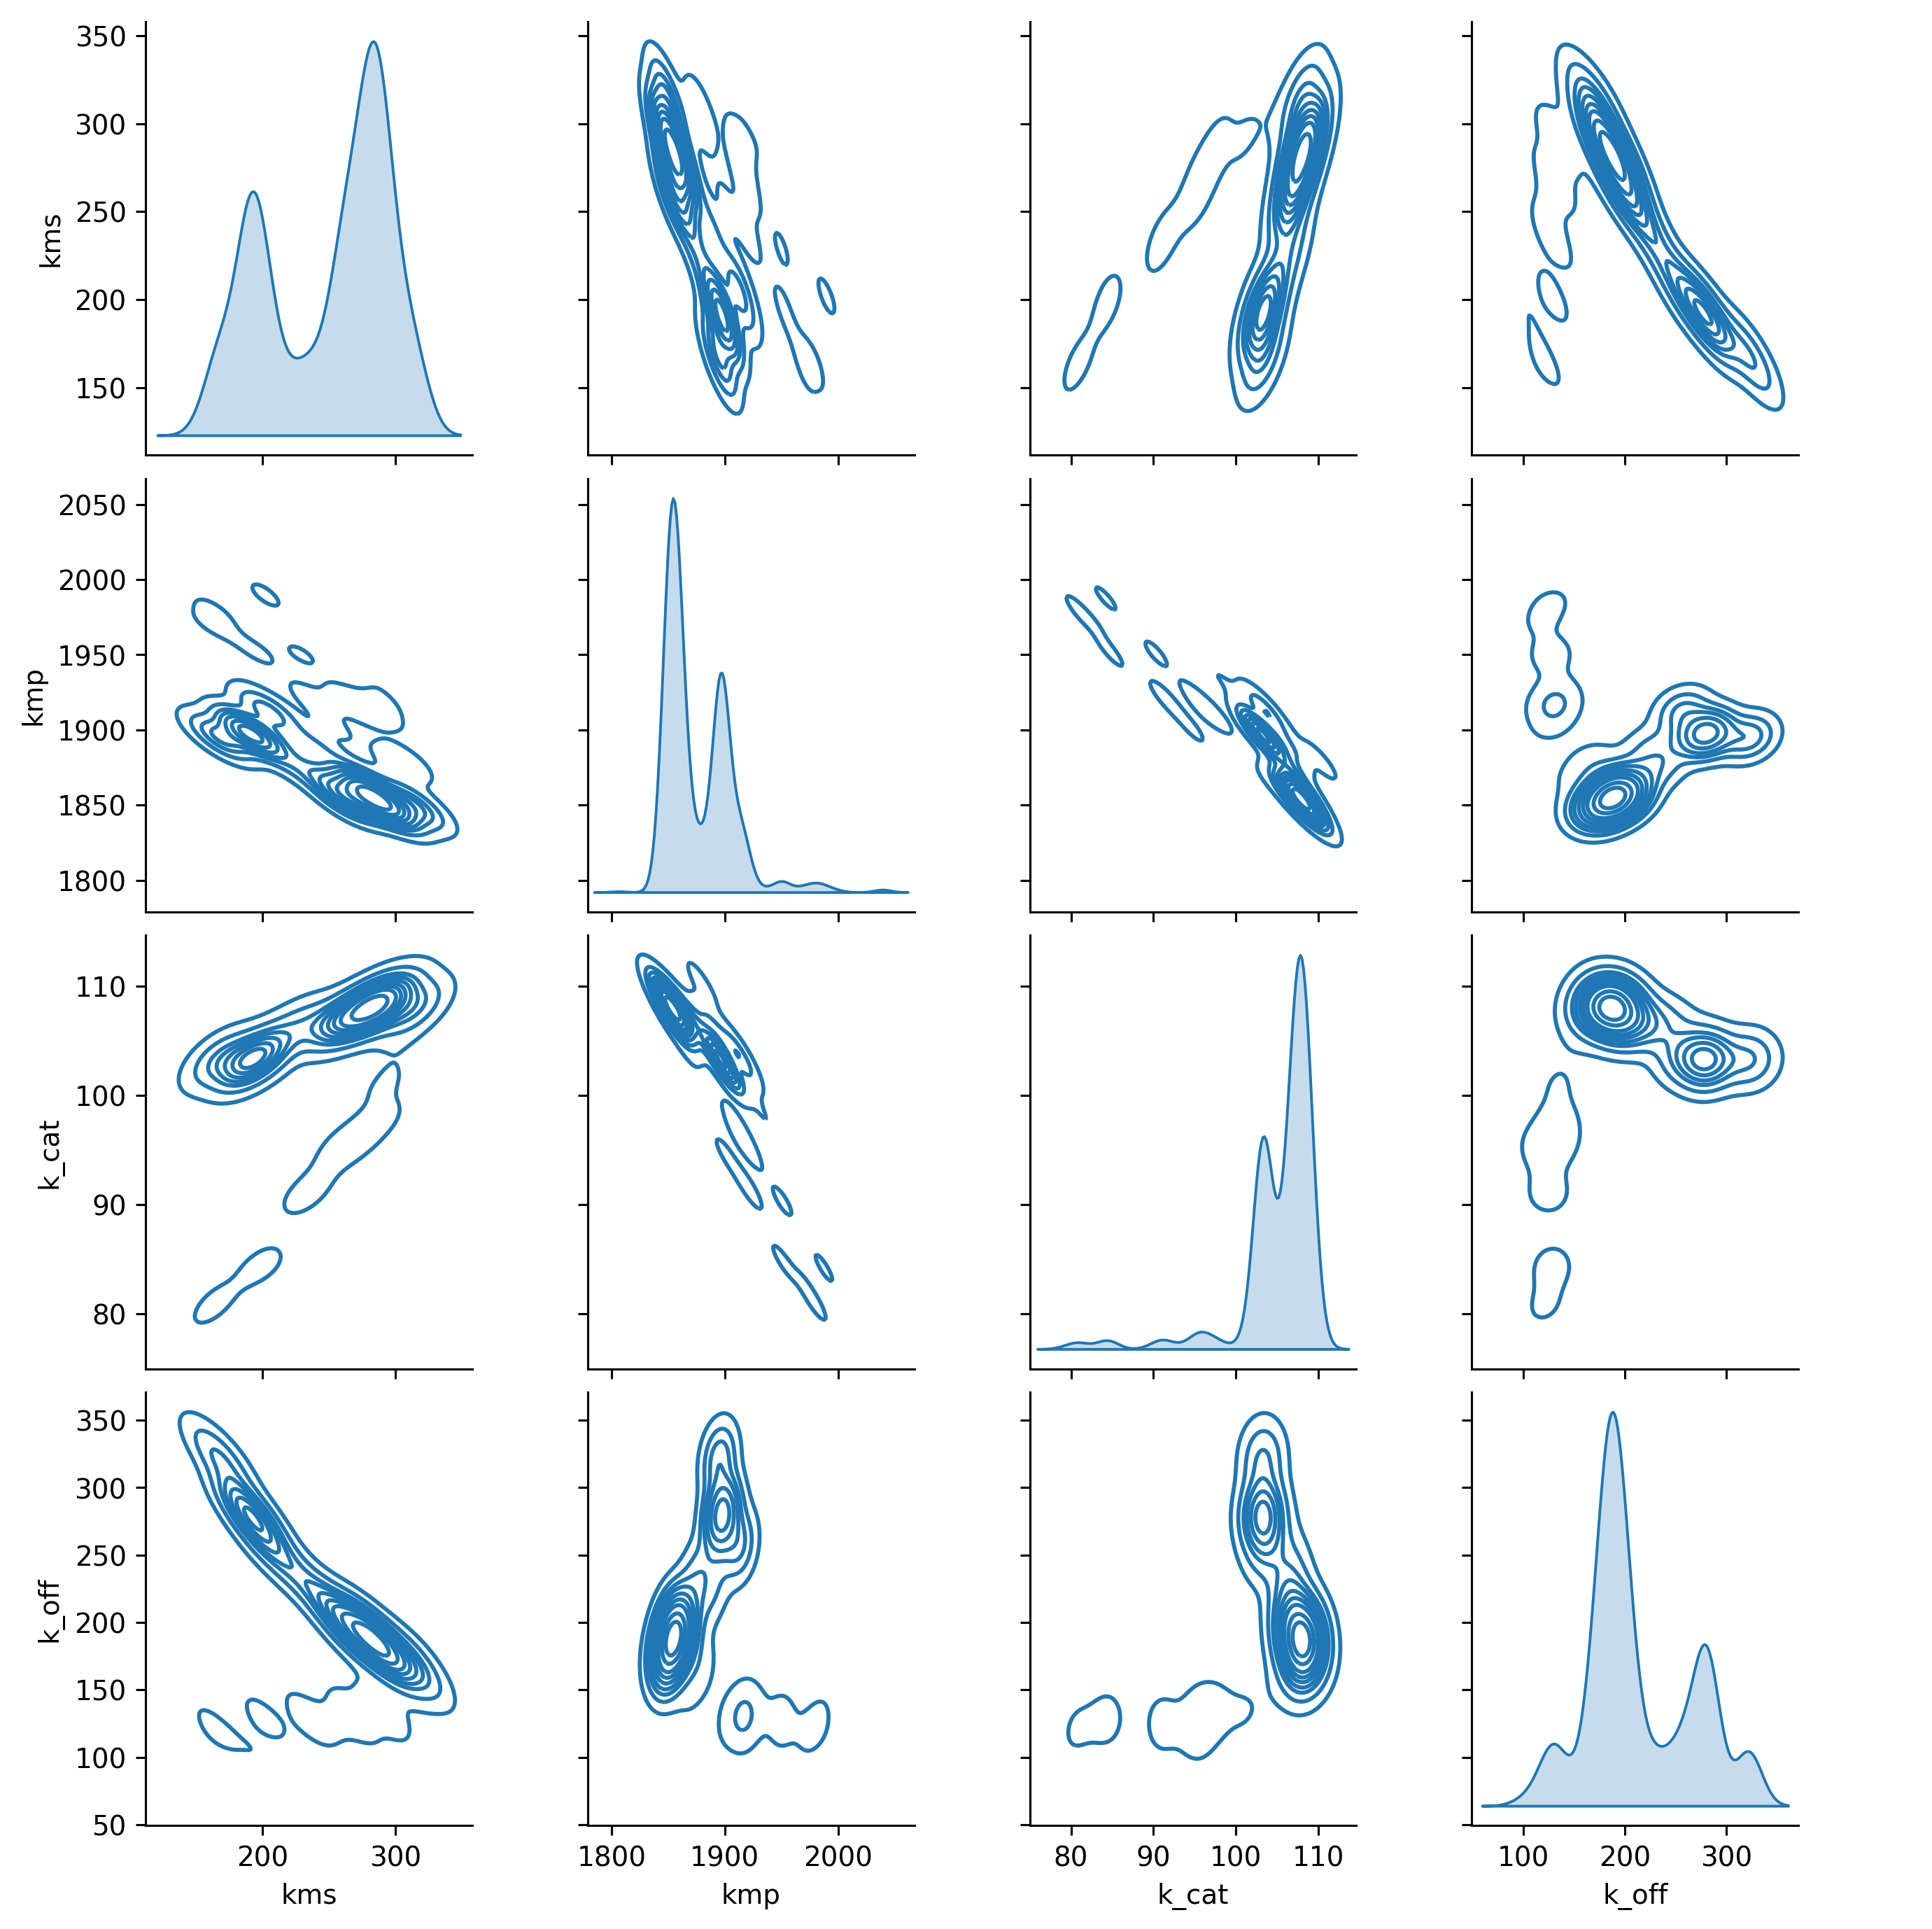

In [179]:
sns.pairplot(chain, kind="kde")

In [180]:
accept_ratio

0.04

In [181]:
pd.DataFrame(cov)

,0,1,2,3
0,2098.532183,-997.484455,123.922103,-1823.662515
1,-997.484455,873.417648,-123.266991,331.330642
2,123.922103,-123.266991,23.117602,14.054959
3,-1823.662515,331.330642,14.054959,2684.146271


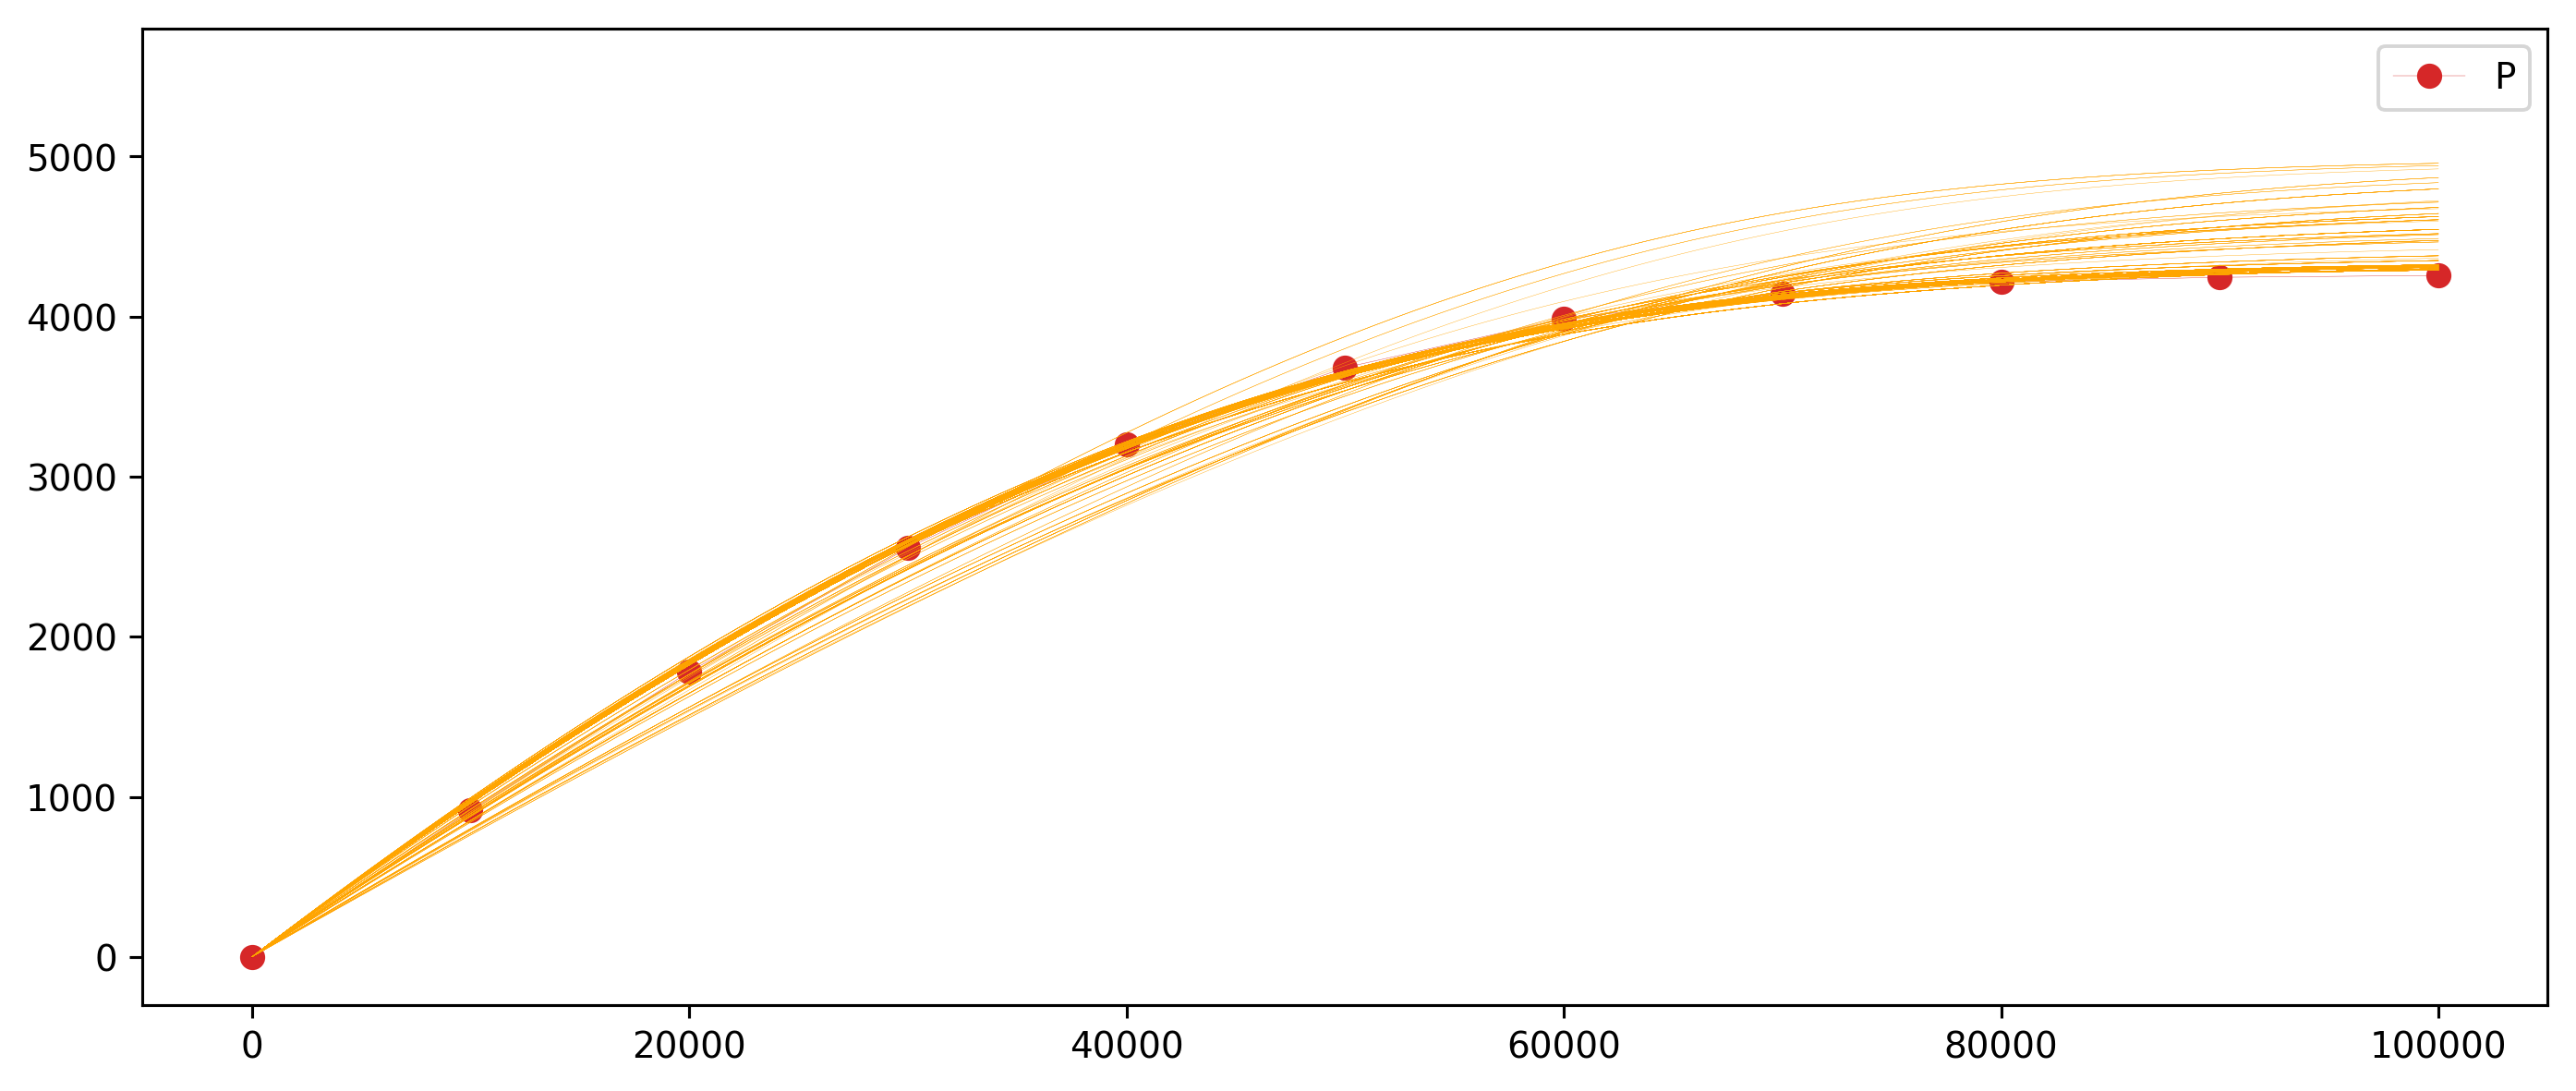

In [182]:
ax = obs.plot.line(marker='o', lw=0.1, color=cmap(3), ylim=(-300, 5800), legend=True)
samples.loc[-100:][samples.columns[::50]].T.plot.line(color='orange', lw=0.1, ax=ax, legend=False)

In [174]:
chain.to_hdf('chain.hdf', 'chain1')
samples.to_hdf('chain.hdf', 'samples1')

# 3. References

- [A Database of Thermodynamic Quantities for the Reactions of Glycolysis and the Tricarboxylic Acid Cycle](https://pubs.acs.org/doi/10.1021/jp911381p)

- [A database of thermodynamic properties of the reactions of glycolysis, the tricarboxylic acid cycle, and the
pentose phosphate pathway](https://academic.oup.com/database/article/doi/10.1093/database/bar005/462082)

- [Thermodynamics of Glycolysis](https://chem.libretexts.org/Bookshelves/General_Chemistry/Book%3A_Structure_and_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_(Schaller)/III%3A_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_1/08%3A_Mechanisms_of_Glycolysis/8.08%3A_Thermodynamics_of_Glycolysis)

- [BKMS-React database entry for glycolysis](http://bkms-react.tu-bs.de/pathway.php?pw_id=pw_glycolysis&ecno=1.2.1.12&id=50)

- [Bistability in Glycolysis Pathway as a Physiological Switch in Energy Metabolism](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098756#pone.0098756.s012)

- [Determination of the rate of hexokinase-glucose dissociation by the isotope-trapping method](https://www.jbc.org/content/249/16/5163.full.pdf)

- [Quantitative Fundamentals of Molecular and Cellular Bioengineering](https://mitpress.mit.edu/books/quantitative-fundamentals-molecular-and-cellular-bioengineering)